In [1]:
import os
import csv
import json
import pandas
import pandas as pd
import copy
import matplotlib as plt
from collections import namedtuple
from datetime import datetime as dt #this is for a time_delta only

%matplotlib inline

In [2]:
# project: p11

In [3]:
# Reusing some code from the previous project

def read_json(path):
    with open(path, encoding='utf-8') as f:
        return json.load(f)
    
def get_mapping(pathname):
    try:
        js = read_json(pathname)
        return js
    except json.JSONDecodeError as jde: 
        return dict()

def get_comment_data(comment_file):
    csv_data = process_csv(comment_file)
    header = csv_data[0] 
    comment_rows = csv_data[1:]
    Comment = namedtuple("Comment", ["video_id", "comment_length", "author_id", "likes", "published_at"])
    
    comment_id_idx = header.index("comment_id")
    video_id_idx = header.index("video_id")
    comment_length_idx = header.index("comment_length")
    author_id_idx = header.index("author_id")
    likes_idx = header.index("likes") 
    published_idx = header.index("published_at")

    final_dict = {}
    for comment in comment_rows:
        if "" in comment or len(comment) != len(header): 
            continue    
        #print(comment[comment_length_idx])
        try:
            C = Comment(comment[video_id_idx], int(comment[comment_length_idx]), comment[author_id_idx], int(comment[likes_idx]),  comment[published_idx])
            final_dict[comment[comment_id_idx]] = C
        except ValueError as ve:
            continue
        
    return final_dict

def bucketize(attribute, videos):
    bucket_dict = {}
    i = 0
    for video in videos: 
        att = videos[video][attribute]

        if type(att) == list:
            for val in att:
                if val not in bucket_dict:
                    bucket_dict[val] = []
                bucket_dict[val].append(video)
        else:
            if att not in bucket_dict:
                bucket_dict[att] = list()
            bucket_dict[att].append(video)
    return bucket_dict

def plot_dict(d, label="Please Label Me!!!"):
    ax = pandas.Series(d).sort_index().plot.bar(color="black", fontsize=16)
    ax.set_ylabel(label, fontsize=16)
    
def process_csv(filename):
    exampleFile = open(filename, encoding="utf-8")  
    exampleReader = csv.reader(exampleFile) 
    exampleData = list(exampleReader)        
    exampleFile.close()  
    return exampleData

def list_files_in(pathname):
    return sorted([item for item in os.listdir(pathname) if item[0] != "."])

def list_paths_in(pathname):
    return sorted([os.path.join(pathname,item) for item in os.listdir(pathname) if item[0] != "."])

files_names = list_files_in("data")
paths = list_paths_in("data")

comment_paths = [path for path in paths if "comment_data" in path]

channel_paths = [path for path in paths if "channel_id" in path]

channel_dict = {}
for channel in channel_paths:
    mapping = get_mapping(channel)
    for mapp in mapping:
        if mapp not in channel_dict:
            channel_dict[mapp] = mapping[mapp]

comments = {}
for file in comment_paths:
    comments.update(get_comment_data(file))
    
comment_buckets = {}
for comment in comments:
    vid_id = comments[comment].video_id
    if vid_id not in comment_buckets:
        comment_buckets[vid_id] = []
    comment_buckets[vid_id].append(comment)

def get_videos(data_file, video_mapping_file):
    # Get data 
    data = process_csv(data_file)
    header = data[0]
    all_videos = data[1:]
    video_mapping = get_mapping(video_mapping_file)
    videos_dict = dict()
    
    for video in all_videos: # You may find it helpful to do all_videos[:5] to only look at the first 5 videos.
        dic = {}
        video_id = video[header.index('video_id')]
        published_at = video[header.index('published_at')]
        duration = video[header.index('duration')]
        category = video[header.index('category')]
        tags = video[header.index('tags')]
        views = video[header.index('views')]
        likes = video[header.index('likes')]
        dislikes = video[header.index('dislikes')]
        channel_id = video[header.index('channel_id')]
        
        try:
            video_title = video_mapping[video_id]
        except:
            continue
        
        if likes == "":
            likes = None
        else: 
            likes = int(likes)
        if dislikes == "":
            dislikes = None
        else: 
            dislikes = int(dislikes)
        if views == "":
            views = None
        else:
            views = int(views)
            
        if comment_buckets[video_id]:
            comments = comment_buckets[video_id]
        else:
            comments = []
        
        ratings_enabled = (likes != None and dislikes != None)
            
        dic = {
            "title": video_title,
            "published_at": published_at,
            "duration": duration,
            "category": category,
            "tags": tags.split("|"),
            "views": views,
            "likes": likes,
            "dislikes": dislikes,
            "channel_name": channel_dict[channel_id],
            "ratings_enabled": ratings_enabled,
            "comments": comments
        }
        
        videos_dict[video_id] = dic
        
    return videos_dict

videos = get_videos(os.path.join('data','video_data.csv'), os.path.join('data','video_ids.json'))

In [4]:
def scatter(x, y, xlabel="please label me!", ylabel="please label me!"):
    df = pd.DataFrame({"x":x, "y":y})
    ax = df.plot.scatter(x="x", y="y", color="black", fontsize=16, ylim=0)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)

In [5]:
def get_all_paths_in(directory):
    lista = []
    paths = list_paths_in(directory)
    for p in paths:
        if os.path.isfile(p):
            if p[0] != ".":
                lista.append(p)
        else:
            lista.extend(get_all_paths_in(p))
    return sorted(lista)


In [6]:
def process_duration(duration_str):

    duration = int(duration_str[0:2]) * 3600 + int(duration_str[3:5]) * 60 + int(duration_str[6:8])
    value = (duration // 300) * 5

    return value

In [52]:
videos_cpy = copy.deepcopy(videos)

for video in videos_cpy:
    videos_cpy[video]["duration"] = process_duration(videos_cpy[video]["duration"])

duration_buckets = bucketize("duration", videos_cpy)
duration_buckets_c = copy.deepcopy(duration_buckets)

for bucket in duration_buckets_c:
    duration_buckets_c[bucket] = len(duration_buckets_c[bucket])

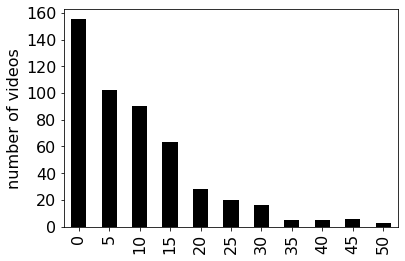

In [53]:
#Q1: Plot the distribution of video durations as a histogram.
plot_dict(duration_buckets_c, "number of videos")

In [55]:
avg_views = {}
hour_bucket = {}

for video in videos:
    dur_f = process_duration(videos[video]['duration'])
    dur = videos[video]['duration']
    hour = videos[video]['published_at'][-8:-6]
    hour = (int(hour)-5)%24
    if dur_f not in avg_views:
        avg_views[dur_f] = []
    if hour not in hour_bucket:
        hour_bucket[hour] = []
    avg_views[dur_f].append(videos[video]['views'])
    hour_bucket[hour].append(videos[video]['views'])
        
for dur in avg_views:
    avg_views[dur] = sum(avg_views[dur])/len(avg_views[dur])

for h in hour_bucket:
    hour_bucket[h] = sum(hour_bucket[h])/len(hour_bucket[h])

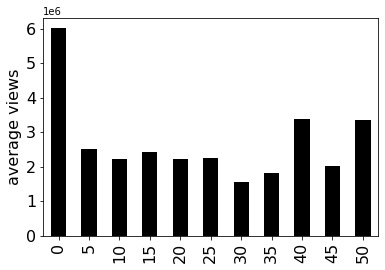

In [56]:
#Q2: Plot the correlation between duration of video (x-axis) and average views (y-axis) as a histogram.
plot_dict(avg_views, "average views")

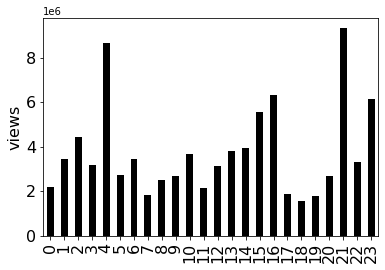

In [58]:
#Q3: Plot the correlation between the hour at which the video is published (x-axis) and the average number of views (y-axis) 
#across all videos in that hour as a histogram.    
plot_dict(hour_bucket, "views")

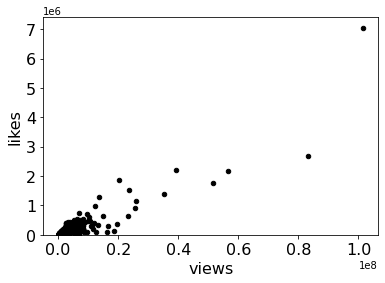

In [60]:
#Q4: Plot the correlation between the views (x-axis) and likes (y-axis) on a video.
x_q4 = [videos[video]['views'] for video in videos if videos[video]['ratings_enabled'] == True]
y_q4 = [videos[video]['likes'] for video in videos if videos[video]['ratings_enabled'] == True]
scatter(x_q4, y_q4, "views", "likes")

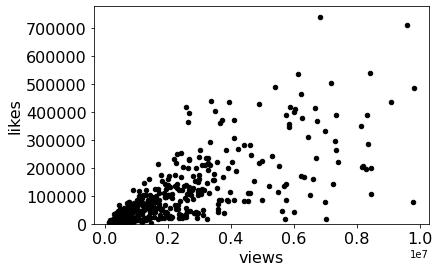

In [17]:
#Q5: Plot the correlation between the views (x-axis) and likes (y-axis) on a video with the outliers removed.
x_q5 = [i for i in x_q4 if i < 10**7]
y_q5 = [y_q4[i] for i in range(len(x_q4)) if x_q4[i] < 10**7]
scatter(x_q5, y_q5, "views", "likes")

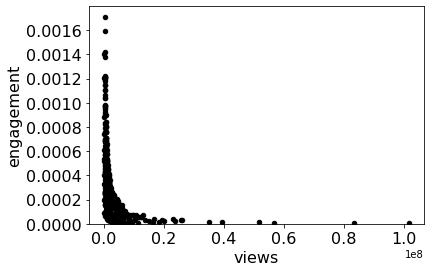

In [19]:
#Q6: Plot the correlation between the views (x-axis) and audience engagement (y-axis) on a video.
x_q6 = [videos[video]['views'] for video in videos]
y_q6 = [len(videos[video]['comments'])/videos[video]['views'] for video in videos]
scatter(x_q6, y_q6, "views", "engagement")

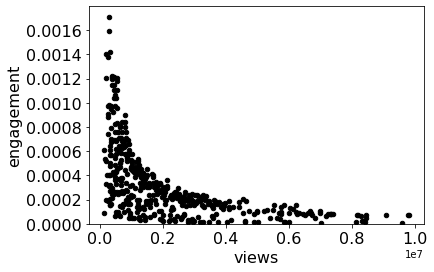

In [21]:
#Q7: Plot the correlation between the views (x-axis) and audience engagement (y-axis) on a 
# video with the outliers removed.
x_q7 = [i for i in x_q6 if i < 10**7]
y_q7 = [y_q6[i] for i in range(len(x_q6)) if x_q6[i] < 10**7]
scatter(x_q7, y_q7, "views", "engagement")

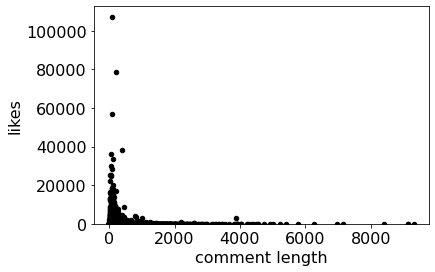

In [23]:
#Q8: Plot the correlation between the length of a comment text (x-axis) and the number of likes
# on the comment (y-axis).
x_q8 = [comments[c].comment_length for c in comments]
y_q8 = [comments[c].likes for c in comments]
scatter(x_q8, y_q8, "comment length", "likes")


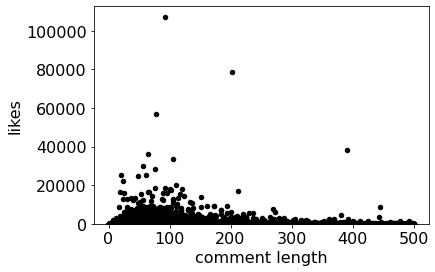

In [25]:
#Q9: Plot the correlation between the length of a comment text (x-axis) and the number of likes on the comment 
#(y-axis) with the outliers removed.
x_q9 = [c for c in x_q8 if c <= 500]
y_q9 = [y_q8[c] for c in range(len(x_q8)) if x_q8[c] <= 500]
scatter(x_q9, y_q9, "comment length", "likes")

In [27]:
def sort_comments_by_published_time(video_title):
    video_id = None
    for video in videos:
        if videos[video]['title'] == video_title:
            video_id = video
            break
    cs = videos[video_id]['comments']
    comment_dict = {}
    for c in cs:
        time = comments[c].published_at
        comment_dict[c] = time
    comment_dict = dict(sorted(comment_dict.items(), key = lambda k : k[-1]))
    return list(comment_dict.keys())
     
assert sort_comments_by_published_time("Out of pocket tik toks 4")[0] == "UgxI96cloxd04ldEkv94AaABAg"

In [28]:
#Q10: What is the length of the first comment under the video "If I lose a boss fight, the video ends 2 
# (Genshin Impact)"?
c_id = sort_comments_by_published_time("If I lose a boss fight, the video ends 2 (Genshin Impact)")[0]
comments[c_id].comment_length

66

In [29]:
#Q11: What is the average number of likes for the first 5 comments under the video 'Facebook, Instagram and 
# WhatsApp down in global outage'?
c_ids = sort_comments_by_published_time('Facebook, Instagram and WhatsApp down in global outage')[0:5]
c_likes = [comments[c].likes for c in c_ids]
sum(c_likes)/len(c_likes)

478.6

In [30]:
def time_delta(start, end):
    '''takes in start and end times in "yyyy-mm-dd hh:mm:ss" format and returns the number of days (as a float) between the two times '''
    start_dt = dt.strptime(start,'%Y-%m-%d %H:%M:%S')
    end_dt = dt.strptime(end, '%Y-%m-%d %H:%M:%S')
    return (end_dt-start_dt).total_seconds()/86400
assert time_delta('2021-11-16 10:00:15', '2021-11-18 08:30:00') == 1.937326388888889


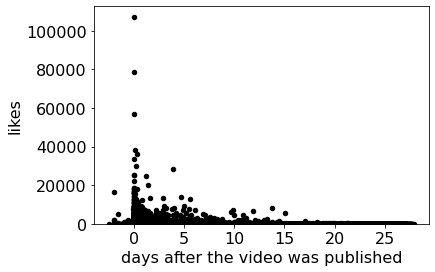

In [31]:
#Q12: Plot the correlation between when a comment is published relative to video publish time (x-axis) and the
#number of likes on the comment (y-axis).
x_q12 = []
y_q12 = []
y_q13 = []
for c in comments:
    if comments[c].video_id in videos:
        time_video = videos[comments[c].video_id]['published_at']
        time_c = comments[c].published_at
        val = time_delta(time_video,time_c)
        x_q12.append(val)
        y_q12.append(comments[c].likes)
        y_q13.append(comments[c].comment_length)
scatter(x_q12, y_q12, "days after the video was published", "likes")

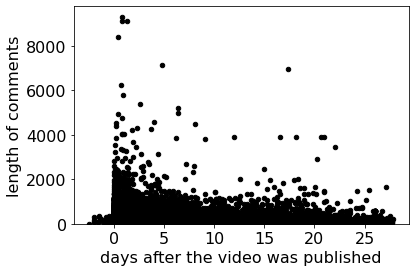

In [33]:
#Q13: Plot the correlation between when a comment is published relative to video publish time (x-axis) and the 
# length of the comment (y-axis).
scatter(x_q12, y_q13, "days after the video was published", "length of comments")

In [35]:
#Q14: What are the paths of the files in the special directory of the broken_file directory?
get_all_paths_in(os.path.join('broken_file','special'))

['broken_file/special/special.json']

In [36]:
#Q15: What are the paths of the files in the rest directory of the non_english directory of 
#the broken_file directory?
get_all_paths_in(os.path.join('broken_file','non_english','rest'))

['broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json']

In [37]:
#Q16: What are the paths of the files in the L_to_Q directory of the english_uppercase directory of the 
# broken_file directory?
get_all_paths_in(os.path.join('broken_file','english_uppercase','L_to_Q'))

['broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json']

In [38]:
#Q17: What are the paths of the files in the broken_file directory?
all_broken_paths = get_all_paths_in('broken_file')
all_broken_paths

['broken_file/english_lowercase/a_to_m/a_to_m.json',
 'broken_file/english_lowercase/rest.json',
 'broken_file/english_uppercase/A_to_E/A/A.json',
 'broken_file/english_uppercase/A_to_E/E.json',
 'broken_file/english_uppercase/A_to_E/rest/rest.json',
 'broken_file/english_uppercase/F_to_K/F_to_H.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/I/I.json',
 'broken_file/english_uppercase/F_to_K/I_to_K/rest.json',
 'broken_file/english_uppercase/L_to_Q/O.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/M.json',
 'broken_file/english_uppercase/L_to_Q/rest/L_to_N/rest/rest.json',
 'broken_file/english_uppercase/L_to_Q/rest/P_to_Q.json',
 'broken_file/english_uppercase/R_to_W.json',
 'broken_file/english_uppercase/rest.json',
 'broken_file/non_english/korean.json',
 'broken_file/non_english/rest/japanese/japanese.json',
 'broken_file/non_english/rest/rest.json',
 'broken_file/non_english/russian/russian.json',
 'broken_file/number.json',
 'broken_file/special/special.json']

In [39]:
#Q18: How many channel mappings are in the files in the broken_file directory?
broken_mapping = {}
for f in all_broken_paths:
    mapping = get_mapping(f)
    for mapp in mapping:
        if mapp not in broken_mapping:
            broken_mapping[mapp] = mapping[mapp]
len(broken_mapping)

18519

In [40]:
#Q19: What is the name of the channel with the channel ID UCwtzSiUayocxaOHLnHe90Hw?
broken_mapping['UCwtzSiUayocxaOHLnHe90Hw']

'Like it Matters'

In [41]:
#Q20: What are the names of the top 5 channels from the broken_file with the most likes on their comments?
c_ids = {}
for c in comments:
    if comments[c].author_id in broken_mapping:
        if comments[c].author_id not in c_ids:
            c_ids[comments[c].author_id] = []
        c_ids[comments[c].author_id].append(comments[c].likes)

for c in c_ids:
    c_ids[c] = sum(c_ids[c])
    
sorted_dict = dict(sorted(c_ids.items(), key = lambda k: k[-1], reverse = True))
lista_ids = list(sorted_dict.keys())[0:5]
lista_names = []
for n in lista_ids:
    lista_names.append(broken_mapping[n])
lista_names

['ChippyGaming',
 'Odin J',
 'A comely black woman',
 'BadBoyHalo',
 'Nakatomino Calamari ']